In [10]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2017)

X_train = []
X_test = []

#for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
for filename in ["gap_VGG19.h5", "gap_InceptionV3.h5"]:    
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

In [11]:
from keras.models import *
from keras.layers import *

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

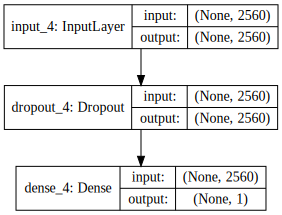

In [12]:
from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot, plot
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
model.fit(X_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2)

/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 2s 112us/step - loss: 0.4191 - acc: 0.8649 - val_loss: 0.0412 - val_acc: 0.9852
Epoch 2/8
20000/20000 [==============================] - 1s 73us/step - loss: 0.0826 - acc: 0.9717 - val_loss: 0.0256 - val_acc: 0.9912
Epoch 3/8
20000/20000 [==============================] - 1s 69us/step - loss: 0.0489 - acc: 0.9830 - val_loss: 0.0217 - val_acc: 0.9924
Epoch 4/8
20000/20000 [==============================] - 1s 73us/step - loss: 0.0423 - acc: 0.9854 - val_loss: 0.0182 - val_acc: 0.9936
Epoch 5/8
20000/20000 [==============================] - 2s 76us/step - loss: 0.0391 - acc: 0.9866 - val_loss: 0.0173 - val_acc: 0.9950
Epoch 6/8
20000/20000 [==============================] - 1s 74us/step - loss: 0.0358 - acc: 0.9886 - val_loss: 0.0167 - val_acc: 0.9948
Epoch 7/8
20000/20000 [==============================] - 1s 71us/step - loss: 0.0301 - acc: 0.9898 - val_loss: 0.0160 - val_acc: 0.995

In [13]:
model.save('model.h5')

In [14]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

12500/12500 [==============================] - 1s 66us/step


In [15]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


In [18]:
def visualize_class_activation_map(img_path, output_path):
    #    model = load_model(model_path)
        original_img = cv2.imread(img_path, 1)
        width, height, _ = original_img.shape

        #Reshape to the network input shape (3, w, h).
        img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
        
        #Get the 512 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = get_output_layer(model, "conv5_3")
        get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]

        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        for i, w in enumerate(class_weights[:, 1]):
                cam += w * conv_outputs[i, :, :]
        print ("predictions".formate(predictions) )
        cam /= np.max(cam)
        cam = cv2.resize(cam, (height, width))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam < 0.2)] = 0
        img = heatmap*0.5 + original_img
        cv2.imwrite(output_path, img)

In [16]:
visualize_class_activation_map('test/1.jpg', "out/1.jpg")

NameError: name 'visualize_class_activation_map' is not defined